# Markov model for CEA
#### Brandon Chan June 2020

Future: 
- GUI inputs and visualization of model structure?
- Speeding up with numba/cython
- Implment in R?

In [1]:
#---------------------------------------------------------------------------------------------------
# Import packages/libraries
#---------------------------------------------------------------------------------------------------
import pandas as pd # Dataframe strucutre and manipulation
import numpy as np # Scientific computing functionality (array and matrix operations and some stats things)
import math # For additional math functions
from arch.bootstrap import IIDBootstrap # For bootstrap calculations

#---------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt # for plotting
import networkx as nx # for network/graphs - not critical

## Accessory functions

In [2]:
#---------------------------------------------------------------------------------------------------
# Helper functions for selecting transition probabilities
#---------------------------------------------------------------------------------------------------
# Not sure how to use yet... but ok.
def get_dirchlet(parameters):
    #Samples a value from the dirchlet distribution based on input parameters
    return np.random.dirichlet(parameters,1)

def get_gamma(mean, variance):
    '''
    Samples a value from the gamma distribution based on an input mean and variance
    Inputs: mean = mean
            variance = variance
    Output: A float between 0 and 1 sampled from the beta distribution defined
            by the input parameters
    '''
    # TODO: Error checking (look at wikipedia too) - consider moving out when checking the spreasheet. (all should be specified correctly before running)
    # mean-var > 1?
    alpha = (mean**2)/(variance**2)  
    beta = (variance**2)/mean
    return np.random.gamma(alpha, beta)

def get_beta(mean, variance):
    '''
    Samples a value from the beta distribution based on an input mean and variance
    Inputs: mean = mean
            variance = variance
    Output: A float between 0 and 1 sampled from the beta distribution defined
            by the input parameters
    '''
    # TODO: Error checking (look at wikipedia too) - consider moving out when checking the spreasheet. (all should be specified correctly before runnin
    # if mean - close to 1 and 0 may return errors
    # if variance is > mean - maybe issues
    alpha = mean*((mean*(1-mean)/variance**2) - 1) #(((1-mean)/variance) - (1/mean)) * mean**2  
    beta = (1-mean)*(mean/variance**2*(1-mean) - 1) #alpha * ((1/mean) - 1)
    return np.random.beta(alpha, beta)

def get_time_dependant(p, const, time, cycle_length):
    '''
    Obtains the transition probaility for a time-dependant transition by sampling the approximated function
    at the given time interval. 
    Inputs: time = time in model, so i in 1:ncycle
            cycle_length = cycle length, in days 
            p = weibull shape parameter from regression. 
            const = constant in regression
    Output: A float between 0 and 1 denoting the time-dependant transition probability from A to B 
            based on the input parameters
    '''
    # TODO:// if other survival curves are being used implment separate return functions? (or add to main "switch")
    return 1-math.exp((math.exp(const))*(((time*cycle_length)-cycle_length)**p)-((math.exp(const))*((t*cycle_length)**p)))

def set_transition(transition_type, params):
    '''
    Function that serves as a switch for a number of transition-probability retriever functions
    Inputs: transition_type = string that denotes which function to redirect params to
            params = a list of values that get passed to a secondary function and will dictate
                     the output
    Output: transition probability sampled/assigned according to the transition_type input
    '''
    if transition_type == 'beta':
        return get_beta(params[0], params[1])
    elif transition_type == 'gamma':
        return get_gamma(params[0], params[1]) 
    elif transition_type == 'time-dependant':
        return get_time_dependant(params[0], params[1], params[2], params[3])
    elif transition_type == 'constant':
        return params[0]
    else:
        raise ValueError('Invalid transition type provided:',str(transition_type))

#---------------------------------------------------------------------------------------------------
# Helper functions related to operations on the transition matrix
#---------------------------------------------------------------------------------------------------
def check_row_sums(matrix):
    '''
    Function that serves soley as a check that all outbound probabilities sum to 1
    Input: matrix = transition matrix of dimensions [num_states x num_states]
    Output: None. Will throw an error and terminate runtime if condition not met
    '''
    row_sums = np.round(matrix.sum(axis=1), 5) # rounding to 5 significant digits for tolerance for close to 1 values
    if np.any(row_sums != 1):
        print(matrix)
        print(row_sums)
        raise ValueError('Error: transitions do no add to 1. Suggest using normalize_transitions()...')

def calculate_residual(matrix, state_index):
    '''
    Function that calculates the residual of all states in the matrix passed
    Inputs: matrix = n x n numpy array representing the transition matrix of the model
            state_index = an integer representing the row of the state that we wish to calculate the residual of
    Output: residual of the outbound transitions
    '''
    row_sum = matrix[state_index, :].sum(axis=1)
    residual = 1 - row_sum
    print(residual)
    return residual
    
def normalize_transitions(matrix):
    '''
    Function that rescales/normalizes the outbound transtions (row-wise) to have a sum of 1
    Input: matrix = transition matrix of dimensions [num_states x num_states]
    Output: matrix rescaled to have each row sum to 1 and each outbound transition scaled appropriately 
    '''
    row_sums = matrix.sum(axis=1)
    return matrix / row_sums[:, np.newaxis] # need newaxis to "reshape" the array so its properly applied

#---------------------------------------------------------------------------------------------------
# Other helper functions
#---------------------------------------------------------------------------------------------------
def check_model_population(pop):
    '''
    Function to check that the entire popoulation is still in the model (ie. no disappearances)
    Input: pop = [1 x number_of_states] numpy array 
    Output: None - raises error if does not sum to 1
    '''
    if round(pop.sum(),5) != 1:
        raise ValueError('Error: proportions do not sum to 1. Loss or gain of population.', round(pop.sum(),5))

def apply_discount(cost, discount_rate, year):
    '''
    Function to apply a provided discount rate to a cost/value at a specified year
    Inputs: cost = value to be discounted
            discount_rate = discount rate 
            year = year in relation to the time horizon (ie. year 1 of 5) not the actual year
    Output: discounted cost/value
    '''
    # floor to year (can be done pre-function call)
    return cost * (1 / ((1+discount_rate)**year))

## Reading in parameters and setting up model

In [4]:
#---------------------------------------------------------------------------------------------------
# Read in excel workbook and assign each sheet to a dataframe
#---------------------------------------------------------------------------------------------------
excel_book = pd.ExcelFile('./model_specifications/test_parameters.xlsx')

transitions_df = pd.read_excel(excel_book, 'transitions')
costs_df = pd.read_excel(excel_book, 'costs')
utilities_df = pd.read_excel(excel_book, 'utilities')
specification_df = pd.read_excel(excel_book, 'specification', header=None, index_col=0)

# Specification of variables regarding states in model
start_state_names = transitions_df['start_state'].unique().tolist()
end_state_names = transitions_df['end_state'].unique().tolist()
unique_states = start_state_names #list(set(start_state_names+end_state_names))
num_states = len(unique_states)

In [5]:
start_state_names

['treatment', 'remission', 'death']

In [6]:
#---------------------------------------------------------------------------------------------------
# Excel file Q/A - checking for specification errors
# If error is detected, an exception will be raised (printed to console) and the program will terminate
#---------------------------------------------------------------------------------------------------

# Check only one unique start-end state pair is defined. (ie. no repeats/multiples of the same transition)
check_multiple = transitions_df.groupby(['start_state','end_state']).size().reset_index().rename(columns={0:'count'})
if (check_multiple['count'] > 1).any():
    print(check_multiple.loc[check_multiple['count'] > 1])
    raise ValueError('Multiple identical defined transitions found. Please check transitions sheet in input excel document')

# Checks that each state has an entry/exit
# TODO: consider that its possible for the entry/start state to be non-reenterable
#       with that in mind its more logical that all states must have an outbound rather than enforcing entry
if np.setdiff1d(start_state_names, end_state_names).shape[0] > 0:
    raise ValueError('State missing exit:',np.setdiff1d(start_state_names, end_state_names).tolist(),'please check transitions sheet in excel document')
elif np.setdiff1d(end_state_names, start_state_names).shape[0] > 0:
    raise ValueError('State missing entry:',np.setdiff1d(end_state_names, start_state_names).tolist(),'please check transitions sheet in excel document')
        
# Check for missing costs 
if np.setdiff1d(unique_states, costs_df['state'].tolist()).shape[0] > 0:
    raise ValueError('Missing cost value for state(s):',np.setdiff1d(unique_states, costs_df['state'].tolist()),'please check cost sheet in excel document')

# Check for missing utilities
if np.setdiff1d(unique_states, utilities_df['state'].tolist()).shape[0] > 0:
    raise ValueError('Missing utility value for state(s):',np.setdiff1d(unique_states, utilities_df['state'].tolist()),'please check utilities sheet in excel document')
    
#---------------------------------------------------------------------------------------------------

In [7]:
#---------------------------------------------------------------------------------------------------
# Generate matrix representation of model
#
# Dimensions of matrix = [num_states x num_states]
# Rows map to starting state, columns map to target state
#---------------------------------------------------------------------------------------------------

# Use dict to map from names to numeric index in array 
state_mapping = {i : unique_states.index(i) for i in unique_states}
#specify empty transition matrix
transition_matrix = np.zeros((num_states,num_states)) 

# Keep track of specific indicies in the transition matrix that need to be updated "in-simulation"
# ie. time-dependant transitions and transitions that get resampled every iteration
# Intended to be stored as a list of dictionaries
resample_indicies = []
time_dependant_indicies = []

# Iterate through specified transtions and initialize values of matrix 
# Log indicies of transitions that need to be updated to quickly index the correct position in the transition matrix
for t in transitions_df.itertuples():
    start_state_index = state_mapping[t[1]] # mapped row number of start state
    end_state_index = state_mapping[t[2]] # mapped column number of end state
    t_type = t[3] # type of transition 
    params = t[4:] # parameters
    
    if t_type in ['beta', 'gamma']:
        resample_indicies += [{'start_state':t[1],'end_state':t[2],'i':start_state_index, 'j':end_state_index, 'type':t_type, 'params':params}]
    elif t_type == 'time-dependant':
        time_dependant_indicies += [{'start_state':t[1],'end_state':t[2],'i':start_state_index, 'j':end_state_index, 'type':t_type, 'params':params}]

    # Initializes the transition matrix with values
    # Optional? - no, we probally want to assign any static transitions here as they would otherwise not be set
    transition_matrix[start_state_index, end_state_index] = set_transition(t_type,params)

# rescale row-wise to ensure row sums (ie. all transitions out of a state sum to 1)
transition_matrix = normalize_transitions(transition_matrix) 

#---------------------------------------------------------------------------------------------------

ValueError: ('Invalid transition type provided:', 'residual')

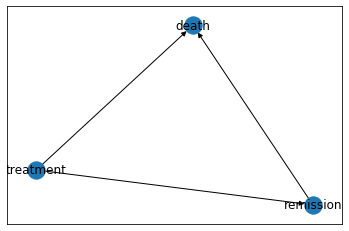

           treatment  remission  death
treatment        0.5       0.25   0.25
remission        0.0       0.50   0.50
death            0.0       0.00   1.00


In [7]:
#from networkx.drawing.nx_agraph import to_agraph
# A = to_agraph(G)
# A.layout('dot')

transition_matrix_pd = pd.DataFrame(transition_matrix, index=unique_states, columns=unique_states)
G = nx.from_pandas_adjacency(transition_matrix_pd, create_using=nx.DiGraph)

#G.graph['edge'] = {'arrowsize':'0.6', 'splines':'curved'}
#G.graph['graph'] = {'scale':'3'}

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, arrows=True)
#nx.draw_networkx_edge_labels(G, pos, arrows=True)
plt.show()

print(transition_matrix_pd)

## Iterativly run model

In [248]:
#---------------------------------------------------------------------------------------------------
# Definining initial parameters 
#---------------------------------------------------------------------------------------------------
# Initialize variables based on spreadsheet defined values
max_iterations = int(specification_df.loc['max_iterations'].values[0])
cycle_length = specification_df.loc['cycle_length'].values[0]
time_horizon_days = specification_df.loc['time_horizon'].values[0] * 360
num_cycles = int(time_horizon_days / cycle_length)
name_start_state = specification_df.loc['name_start_state'].values[0]

# Create result logging array/dataframe 
# Shape: [iteration_number x states x timesteps]
# *timesteps = number of cycles
results_log = np.zeros((max_iterations, num_states, num_cycles))

#---------------------------------------------------------------------------------------------------
# Run the simulation (for a single arm)
# (If in the future want to wrap in a function)
# Input: max_iterations, max_time, transition_matrix
# Output: results_log
#---------------------------------------------------------------------------------------------------
# For iteration until max
for iteration in range(0,max_iterations):
    # Initialize the starting population/proportion for each state at beginning of each model iteration
    # I.e. starting with a zero column-vector of dimension [number_of_states x 1]
    # The initial "proportions" are assigned in accordance to the corresponding row of the vector
    # This corresponds with the row/name assignments of the transition matrix.
    population = np.zeros((num_states,1)) 
    population[state_mapping[name_start_state]] = 1
    '''
    ^ FLAGGED FOR CLARIFICATION 
    - Likely needs some work or initial specification from the excel file built-in
    - TODO: add specification for model start state (ie. which state(s) do we assign the population to at t0?)
    '''
    
    # Initialize with population at time 0 (ie. first cycle everyone is in tx_1 or whereever presumablly)
    results_log[iteration, :, 0] = population.reshape(num_states)
    
    # Initialize as 1 at every iteration becasue population at 0 is always the same at the beginning of
    # any given iteration?
    cycle = 1
    time = 0

    # Resample transition probailities if needed (ie. from distributions) - Update matrix as appropriate
    for t in resample_indicies:
        transition_matrix[t['i'],t['j']] = set_transition(t['type'],t['params'])  
    transition_matrix = normalize_transitions(transition_matrix) # normalize sampling
    check_row_sums(transition_matrix) # Check if row sums are == 1
    
    #----------------------------------------------------------------------------------
    # For every timestep until max is reached
    while cycle < num_cycles:
        # Adjust time-dependant transition probabilities based on timestep if needed
        for t in time_dependant_indicies:
            transition_matrix[t['i'],t['j']] = set_transition(t['type'],t['params']+[time])
        transition_matrix = normalize_transitions(transition_matrix) # Update matrix (certian i,j based on variable time)? - TODO this "targeted" functionality
        check_row_sums(transition_matrix) # Check if row sums are == 1
        
        # Initialize a temperary zero vector to log the updated population proportions
        new_population = np.zeros(population.shape)
        
        #------------------------------------------------------------------------------
        # Calculate the movement for the "population" in each state to another
        # ie. sum them up per state
        # population as a col vector basically 
        for i in range(0,population.shape[0]):
            movements = transition_matrix[i,:] # isolate possible transitions for the specific state
            
            #--------------------------------------------------------------------------
            # apply/redistribute the population based on the current value of the state and the defined 
            # transition probabilities
            for j in range(0,movements.shape[0]):
                new_population[j] += population[i]*movements[j]
        
        population = new_population # Assign updated population-proportion numbers
        
        # Check: does population sum to 1? (assuming a round to 5 significant digits hold)
        check_model_population(population)
        
        # Update results_log after ever timestep
        results_log[iteration, :, cycle] = population.reshape(num_states) 
        
        time += cycle_length # increment time based on cycle length
        cycle += 1 # next cycle
        
#---------------------------------------------------------------------------------------------------

In [9]:
transition_matrix_pd

,treatment,remission,death
treatment,0.5,0.25,0.25
remission,0.0,0.50,0.50
death,0.0,0.00,1.00


In [10]:
results_log.shape

(1000, 3, 6)

In [249]:
results_log[0,:,:]

array([[1.      , 0.5     , 0.25    , 0.125   , 0.0625  , 0.03125 ],
       [0.      , 0.25    , 0.25    , 0.1875  , 0.125   , 0.078125],
       [0.      , 0.25    , 0.5     , 0.6875  , 0.8125  , 0.890625]])

# Cost and utility calculations

In [ ]:
# SAMPLE COSTS AND UTILITIES PER-ITERATION
# 1D vector of these => [number_of_iterations, 1] each entry samples from distributions (value/variance) - only if applicable

In [89]:
# Condense "grouped states"
# well identifying them should be enough for cost/utility mapping
remission_indicies = [state_mapping[s] for s in state_mapping if 'remission' in s] # would get all indicies with "remission" in them 
rest_indicies = [state_mapping[s] for s in state_mapping if 'rest' in s] # would get all indicies with "remission" in them 

In [101]:
print(sum(np.array([0.2,0.1,0.15])*20.25))
print(str(0.45 * 20.25))

9.112499999999999
9.1125


In [13]:
condensable_state_mappings = {}
multiple_toxicity_states = {}

In [14]:
# Theroetically "faster" to move this into the proportion loops?
results_log_costs = np.zeros(results_log.shape)
results_log_utilities = np.zeros(results_log.shape)

for iteration in range(0,max_iterations):
    for state in state_mapping:
        idx = state_mapping[state]
        
        # TODO: add loose string matching or precompute associated indicied for "repeat states" (ie. rest or remission)
        # When mapping to the utility/cost tables, it will match based on the "condensed" state name
        if state in condensable_state_mappings:
            state = condensable_state_mappings['state']
            
        # TODO: add "division" of treatment states for cost or utility? How to effectivley do this...
        if state in multiple_toxicity_states:
            multiple_toxicity_states['state']
            results_log[iteration,idx,:] # is proportion of pts in that patient at every time iterations
            
            results_log_costs[iteration,idx,:] = results_log[iteration,idx,:] * costs_df.loc[costs_df.state==state].cost.values[0] #cost_array[row,iteration]
            results_log_utilities[iteration,idx,:] = results_log[iteration,idx,:] * utilities_df.loc[utilities_df.state==state].utility.values[0] #utility_array[row,iteration]
        else:
            # multiply every (proportion) entry with the cost/utility associated with that state at that iteration
            # assign result to utility/cost array
            results_log_costs[iteration,idx,:] = results_log[iteration,idx,:] * costs_df.loc[costs_df.state==state].cost.values[0] #cost_array[row,iteration]
            results_log_utilities[iteration,idx,:] = results_log[iteration,idx,:] * utilities_df.loc[utilities_df.state==state].utility.values[0] #utility_array[row,iteration]
        
#calculate sum at each time point (assign to bottom row)
# result array shape: [num_iterations, num_timesteps]
# each row is the sum of the costs/utilitys at time point t of an iteration
costs_sums_per_time = np.sum(results_log_costs,axis=1)
utility_sums_per_time = np.sum(results_log_utilities,axis=1)

#calculate sum of sums = cost of iteration / utility of iteration / (lyg comes from comparing two arms)
costs_sums_per_iteration = np.sum(costs_sums_per_time,axis=1)
utility_sum_per_iteration = np.sum(utility_sums_per_time,axis=1)

In [15]:
costs_sums_per_time = np.sum(results_log_costs,axis=1)
print(costs_sums_per_time)
costs_sums_per_iteration = np.sum(costs_sums_per_time,axis=1)
print(costs_sums_per_iteration)

[[100.     50.     25.     12.5     6.25    3.125]
 [100.     50.     25.     12.5     6.25    3.125]
 [100.     50.     25.     12.5     6.25    3.125]
 ...
 [100.     50.     25.     12.5     6.25    3.125]
 [100.     50.     25.     12.5     6.25    3.125]
 [100.     50.     25.     12.5     6.25    3.125]]
[196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.87

In [16]:
results_log_costs = np.zeros(results_log.shape)
results_log_utilities = np.zeros(results_log.shape)
for state in state_mapping:
    idx = state_mapping[state]

    # TODO: add loose string matching or precompute associated indicied for "repeat states" (ie. rest or remission)
    # When mapping to the utility/cost tables, it will match based on the "condensed" state name
    if state in condensable_state_mappings:
        state = condensable_state_mappings['state']

    # TODO: add "division" of treatment states for cost or utility? How to effectivley do this...
    if state in multiple_toxicity_states:
        multiple_toxicity_states['state']
        results_log[:,idx,:] # is proportion of pts in that patient at every time iterations

        results_log_costs[:,idx,:] = results_log[:,idx,:] * costs_df.loc[costs_df.state==state].cost.values[0] #cost_array[row,iteration]
        results_log_utilities[:,idx,:] = results_log[:,idx,:] * utilities_df.loc[utilities_df.state==state].utility.values[0] #utility_array[row,iteration]
    else:
        # multiply every (proportion) entry with the cost/utility associated with that state at that iteration
        # assign result to utility/cost array
        results_log_costs[:,idx,:] = results_log[:,idx,:] * costs_df.loc[costs_df.state==state].cost.values[0] #cost_array[row,iteration]
        results_log_utilities[:,idx,:] = results_log[:,idx,:] * utilities_df.loc[utilities_df.state==state].utility.values[0] #utility_array[row,iteration]


In [17]:
costs_sums_per_time = np.sum(results_log_costs,axis=1)
print(costs_sums_per_time)
costs_sums_per_iteration = np.sum(costs_sums_per_time,axis=1)
print(costs_sums_per_iteration)

[[100.     50.     25.     12.5     6.25    3.125]
 [100.     50.     25.     12.5     6.25    3.125]
 [100.     50.     25.     12.5     6.25    3.125]
 ...
 [100.     50.     25.     12.5     6.25    3.125]
 [100.     50.     25.     12.5     6.25    3.125]
 [100.     50.     25.     12.5     6.25    3.125]]
[196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875 196.875
 196.875 196.875 196.875 196.87

# Bootstrap analysis

In [39]:
# Group remission states (group proportions)
# Group rest states (group proportions)

# discount rates applied

# Bootstrapping code snippet (example with 1000 random numbers)
from arch.bootstrap import IIDBootstrap
def func(x):
    return x.mean()
bs = IIDBootstrap(np.random.rand(1000))
ci = bs.conf_int(func, 1000, method='bca') #bias-corrected and accelerated method

# OLD

In [2]:
# What you get at the start:
# treat_name
# start_state
# end_state
# probability

# time dependancy?
# need to log a time
transition_names = [['treatment_treatment'],['treatment_rest'],['treatment_death'],['treatment_remission'],['treatment_next'],
                    ['rest_rest'],['rest_death'],['rest_next'],
                    ['remission_remission'],['remission_next']]

# End: Multiple sequences of 

In [6]:
# Thoughts: Acceleration with numba is all numpy arrayed
# parallel processing?

# Reading from file?
# Excel parsing would be easiest
# Think about systematic ways of validating that the specification is correct? ( i suppose row_sum = 1 would do this )
# Dichlet dist has 3 parameters
# Need: ['source','target','type of dist','mean','variance']
# Need: Time dependant things... how to represent in the file? 
#       ['shape parameter 1', 'shape parameter 2', 'time'] {although time is not to be represented in the file}
#       use scipy 

#--------------------------------------------------------------------------------------
# Define the transitions as a matrix
#--------------------------------------------------------------------------------------
states = ['treatment', 'remission', 'death']
df = pd.DataFrame(np.zeros((3,3)), index=states, columns=states)

# ['source', 'target'] = probability 

df.loc['treatment','treatment'] = .5
df.loc['treatment','remission'] = .25
df.loc['treatment','death'] = .25

df.loc['remission','death'] = .5
df.loc['remission','remission'] = .5

df.loc['death','death'] = 1

matrix = df.values
population = np.array([1,0,0])
population.shape = (3,1)

#trasition_matrix_df = pd.DataFrame(np.zeros((num_states,num_states)), index=unique_states, columns=unique_states)
#trasition_matrix_df.values

        
#print(population)

# Extra scratch code 
#print(np.matmul(matrix,population))

#print(matrix)
# Thoughts:
# .apply to update dataframe with time dependent?
# function to check row sum == 1

#df = pd.crosstab(df.start, df.end)
#print (df)


#set_transition = {'beta':get_beta,
#                 'gamma':get_gamma,
#                 'time-dependent':get_time_dependant,
#                 'static':get_static}
#set_transition['beta'](0.6,0.002) # Theroetical call of the function based on matching the key in the dictionary

# Fast track/index where to update matrix M at every iteration
'''
time_dependent_transitions = [{'idx':[i,j], 'dist':'time_dependent', 'a':a, 'b':b}
                              ,[i,j],[i,j],...]
stochastic_transitions = [[i,j],[i,j],[i,j],...]
'''
'''
for row with stochastic transition probabilities:
    normalize
    transitions = [p1, p2, ..., pN]
scaled_transitions = [float(t)/sum(tansitions) for t in transitions]
update M
'''


In [ ]:
tra

In [ ]:
model_helpers.calculate_residual()

In [22]:
import math
import matplotlib.pyplot as plt

In [123]:
get_time_dependant(-5.354, -1.062, 1, 30)

OverflowError: math range error

In [46]:
def get_time_dependant2(shape, scale, time, cycle_length):
    '''
    Obtains the transition probaility for a time-dependant transition by sampling the approximated function
    at the given time interval. 
    Inputs: time = time in model, so i in 1:ncycle
            cycle_length = cycle length, in days 
            p = weibull shape parameter from regression. 
            const = constant in regression
    Output: A float between 0 and 1 denoting the time-dependant transition probability from A to B 
            based on the input parameters
    '''
    x1 = ((t)*cycle_length)#/365 # Proportion of a year
    x2 = ((t+1)*cycle_length)#/365 # Proportion of a year
    # TODO:// if other survival curves are being used implment separate return functions? (or add to main "switch")
    
    
    #print(x1, x2)
    
    #return 1 - math.exp(scale * (((x1)**shape) - ((x1+1)**shape)))
    #return 1-math.exp((math.exp(scale))*(x1**shape)-((math.exp(scale))*(x2**shape)))

    return 1 - math.exp((x1/scale)**shape - (x2/scale)**shape)


In [17]:
get_time_dependant2(sp,sc,0,30)

0.972982388304231

In [51]:
sc = 100.412
sp = 1.034
tp=[]
for t in range(0,60):
    tp += [get_time_dependant2(sp,sc,t,30)]

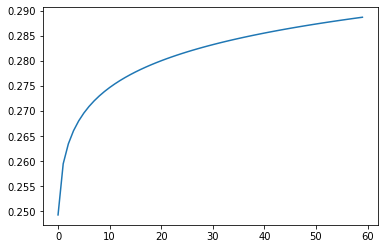

In [52]:
plt.plot(range(0,60),tp)

(500,)


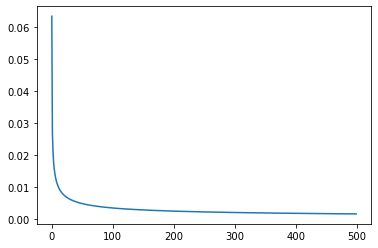

In [14]:
def wfn(const, p, t, cycle_length):
    '''
    shape = k
    '''
    return 1-math.exp(const)*((t*cycle_length)**p)

#def sample_weibull(shape, scale, t, cycle_length):

def sample_weibull_pdf(shape, scale, t, cycle_length):
    x = (t*cycle_length)/365
    if x < 0:
        return 0
    return (shape/scale)*((x/scale)**(shape-1))*math.exp(-(x/scale)**shape)

def sample_weibull_cdf(shape, scale, t, cycle_length):    
    '''
    returns the value of the CDF at a particular time of a weibull defined
    by the two parameters shape and scale.
    shape = k
    scale = lambda
    '''
    x = t #(t*cycle_length)/365 # Proportion of a year (assuming original curve x units are years)
    if x < 0:
        return 0
    return 1 - math.exp(-(x/scale)**shape) # this is the CDF
    #return (shape/scale)*(((t*cycle_length)/scale)**(shape-1)) * math.exp(-((t*cycle_length)/scale)**shape)

def get_time_dependant_transition(shape, scale, t, cycle_length):
    '''
    1 - CDF = survival function
    Taking the difference in survival function between consecutive cycles in the model
    '''
    #return (1-(sample_weibull_cdf(shape, scale, t, cycle_length)) - (1-sample_weibull_cdf(shape, scale, t+1, cycle_length)))
    return (1-math.exp(((t*cycle_length)/scale)**shape)) - (1-math.exp((((t+1)*cycle_length)/scale)**shape))

def get_time_dependant3(shape, scale, time, cycle_length):
    '''
    Obtains the transition probaility for a time-dependant transition by sampling the approximated function
    at the given time interval. 
    Inputs: time = time in model, so i in 1:ncycle
            cycle_length = cycle length, in days 
            p = weibull shape parameter from regression. 
            const = constant in regression
    Output: A float between 0 and 1 denoting the time-dependant transition probability from A to B 
            based on the input parameters
    '''
    # TODO:// if other survival curves are being used implment separate return functions? (or add to main "switch")
    
    t1 = (time*cycle_length) / 365
    t2 = ((time+1)*cycle_length) / 365
    
    #return 1-math.exp((t1/scale)**shape - (t2/scale)**shape)
    return 1-math.exp(scale*t1**shape - scale*t2**shape)
    
p = -0.2830618 #-0.0451541
const = 0.2424928 #0.4831473
# -0.2830618	0.2424928

cycle_length = 30
x = np.arange(0,(500)) #cycles in model
y = np.zeros((x.shape[0]))
y2 = np.zeros((x.shape[0]))
i = 0 

print(x.shape)
for num in x:
    y[i] = get_time_dependant3(0.505728,0.231929,num,cycle_length)
    y2[i] = 1-get_time_dependant3(0.505728,0.231929,num,cycle_length)#sample_weibull_cdf(0.505728,0.231929,num+1,cycle_length) - sample_weibull_cdf(0.505728,0.231929,num,cycle_length)
    i+=1
#plt.plot(x, wfn(const, p, x, cycle_length))
#print(weibull(p, const, 1, cycle_length))
plt.plot(x, y)
#plt.plot(x, y2)

In [17]:
y

array([0.06344505, 0.02714406, 0.02095847, 0.01773262, 0.01566194,
       0.01418646, 0.01306575, 0.01217678, 0.01144911, 0.01083909,
       0.01031802, 0.00986613, 0.00946934, 0.00911725, 0.00880205,
       0.0085177 , 0.00825946, 0.00802356, 0.00780695, 0.00760712,
       0.00742202, 0.00724992, 0.00708936, 0.0069391 , 0.00679808,
       0.0066654 , 0.00654026, 0.00642197, 0.00630992, 0.00620359,
       0.00610251, 0.00600625, 0.00591444, 0.00582676, 0.00574289,
       0.00566258, 0.00558556, 0.00551164, 0.0054406 , 0.00537225,
       0.00530645, 0.00524302, 0.00518183, 0.00512275, 0.00506567,
       0.00501046, 0.00495704, 0.00490531, 0.00485517, 0.00480656,
       0.00475939, 0.00471359, 0.0046691 , 0.00462585, 0.0045838 ,
       0.00454288, 0.00450305, 0.00446425, 0.00442645, 0.0043896 ,
       0.00435367, 0.00431861, 0.00428439, 0.00425097, 0.00421834,
       0.00418645, 0.00415528, 0.0041248 , 0.00409498, 0.00406581,
       0.00403726, 0.00400931, 0.00398193, 0.00395511, 0.00392

[1, 0.9210952933439548, 0.8541512351788522, 0.7969708852092449, 0.7478281805374096, 0.7053541975421977, 0.6684536355553944, 0.6362428306029462, 0.6080032818253747, 0.5831464749479816, 0.5611870161507858, 0.5417219378363793, 0.5244146296389821, 0.5089822653712419, 0.49518589385913525, 0.48282257534441836, 0.4717191001984588, 0.4617269401624972, 0.4527181660457084, 0.4445821280599135, 0.43722274160004193, 0.43055625646010603, 0.42450941419808497, 0.4190179187953037, 0.4140251614755081, 0.409481152715257, 0.40534162394770307, 0.40156726887430066, 0.3981231001313264, 0.39497790167042557, 0.3921037608776743, 0.38947566738194933, 0.3870711678502251, 0.3848700679576492, 0.3828541742490605, 0.3810070698500575, 0.3793139189977159, 0.3777612961890639, 0.37633703642534383, 0.37503010359033545, 0.3738304744642125, 0.3727290362586022, 0.37171749587820047, 0.3707882993811136, 0.36993456033345445, 0.3691499959412463, 0.3684288700005707, 0.3677659418401985, 0.3671564205437953, 0.3665959238345873, 0.36

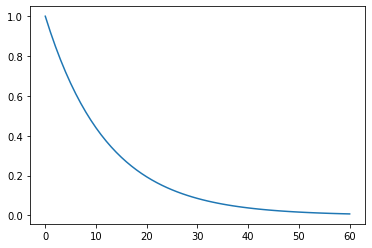

In [246]:
p = 1
p_array = [p]
tp_array = []
for t in range(0,60):
    tp =  (1 - (sample_weibull_cdf(1,1,t,30)) - (1-sample_weibull_cdf(1,1,t+1,30)))
    p = p - (p*tp)
    p_array += [p]
    tp_array += [tp]
print(p_array)
print(tp_array)
plt.plot(list(range(0,61)),n)

In [254]:
f1 = 0.75
f2 = 0.5
(f1 - f2) / f1

0.3333333333333333

In [221]:
sample_weibull_cdf(1,1,1,30)

0.07890470665604521

In [230]:
t1 = 10
t2 = t1+1
(sample_weibull_cdf(1,1,t1,30)) - (sample_weibull_cdf(1,1,t2,30))

-0.034685546447454474

In [178]:
1 - sample_weibull(1,1,1,30)

0.9210952933439548

In [171]:
1 - sample_weibull(1,1,2,30)

0.8484165394203861

In [95]:
1-math.exp((math.exp(const))*(((time*cycle_length)-cycle_length)**p)-((math.exp(const))*((t*cycle_length)**p)))

NameError: name 'const' is not defined

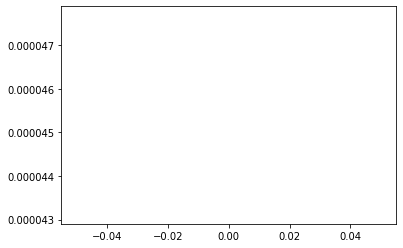

In [118]:
from scipy.stats import weibull_min

rv = weibull_min(1)
plt.plot(rv.pdf(10))

In [93]:
β0 = -5.354
SE = 1.811
σ = -1.062
SE = 0.664 


2.718281828459045

In [36]:
get_beta(0.5,0.1)

0.3853247683811793

In [57]:
a = np.zeros((3,10000))
for i in range(0,10000):
    a[:,i] = np.random.dirichlet([1,1,1])
a.mean(axis=1)

array([0.33147366, 0.33570616, 0.33282018])

In [87]:
from scipy.stats import dirichlet

dirichlet.mean([0.001,1,1])

array([0.00049975, 0.49975012, 0.49975012])

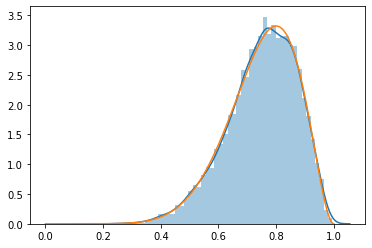

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

def plot_beta(x_range, a, b, mu=0, sigma=1, cdf=False, **kwargs):
    x = x_range
    if cdf: 
        y = ss.beta.cdf(x,a,b,mu,sigma)
    else:
        y = ss.beta.pdf(x,a,b,mu,sigma)
        
    plt.plot(x,y,*kwargs)

    
rb = np.random.beta(8+1, 2+1, size=10000)
sns.distplot(rb)

x = np.linspace(0,1,5000)
plot_beta(x, 8+1, 2+1)

plt.show()



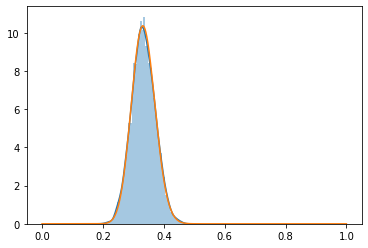

In [308]:
rb = np.random.beta(a, b, size=10000)
sns.distplot(rb)

x = np.linspace(0,1,5000)
plot_beta(x, 50, 100)

plt.show()

In [309]:
a = 50
b = 1000
mean = a/(a+b)
var = (a+b)/(((a+b)**2)*(a+b+1))
print(mean,var)

0.047619047619047616 9.061664627792125e-07


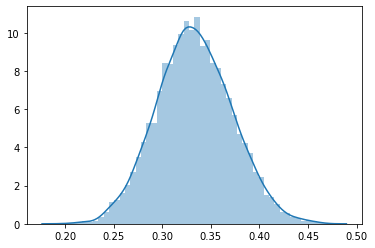

In [325]:
rb2 = np.zeros((10000))
for i in range(0,10000):
    rb2[i] = get_beta(mean, var)
#sns.distplot(rb2)
sns.distplot(rb)